# Determine trade-off between data-set size and number of basins in the dataset
We started the project with the gauges from the CAMELS-US data set complemented with Canadian gauges in the Reference Hydrometric Basin Network. Several basins in the RHBN data set are very large and will thus require a lot of disk space when we process forcing data for them. 

Here we:
1. Subset 1 month of ERA5 data to the individual basins
2. Estimate the ERA5 disk space needed for each basin, using this single month and knowledge about the time period of interest of each basin as guides
3. Use this information to draw a line at a basin area above which we exclude the basins from the data set

In [1]:
import os, glob, sys
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')
basins_path = Path(data_path) / cs_basin_folder

# Temporary download path
temp_folder = Path( cs.read_from_config(config_file, 'temp_path') )

In [4]:
#fig_folder = Path(data_path) / cs_meta_path / 'images_forcing_coverage_era5/
#fig_folder.mkdir(parents=True, exist_ok=True)

### Data loading

In [5]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [6]:
# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object})

## Processing

In [7]:
# Find the ERA5 files
era5_invariant = glob.glob(str(temp_folder/'*invariants.nc'))[0] # String
era5_surface = sorted(glob.glob(str(temp_folder/'*surface_variables.nc')))[0] 
era5_pressure = sorted(glob.glob(str(temp_folder/'*pressure_variables.nc')))[0] 

In [8]:
debug_message = f'\n!!! CHECK DEBUGGING STATUS: \n- full run in progress \n'

In [12]:
# Create empty lists
country = []
station_id = []
area_km2 = []
data_days_needed = []
data_size_one_month_kb = []
number_of_hrus = []

print(debug_message)
for ix,row in cs_meta.iterrows():
    
    # Get shapefile path to determine download coordinates, and forcing destination path
    basin_id, shp_lump_path, shp_dist_path, _, _ = cs.prepare_delineation_outputs(cs_meta, ix, Path(data_path)/cs_basin_folder)
    raw_fold, _, _ = cs.prepare_forcing_outputs(cs_meta, ix, Path(data_path)/cs_basin_folder) # Returns folders only, not file names
    print('--- Now running basin {}. {}'.format(ix, basin_id))
    
    # From shapefile, get bounding coordinates. Then determine download coordinates from those
    bounds = cs.find_shapefile_bounds(shp_lump_path)
    coords_era5, _, _ = cs.find_download_coords_from_bounds(bounds, target='ERA5')
    
    # Check if we need to run downloads for this station at all
    missing = cs.flow_obs_unavailable(cs_unusable, row.Country, row.Station_id)
    if 'iv' in missing and 'dv' in missing: 
        continue # with next station, because we have no observations at all for this station
  
    # Subset the two data files - we'll ignore the invariants because they take up relatively little space
    for infile in [era5_surface, era5_pressure]:
        outfile = raw_fold/os.path.basename(infile)
        cs.extract_ERA5_subset(infile,outfile,coords_era5)

    # Track how many months of data we expect for this station
    times_flow = cs.find_flow_obs_times_from_metadata(row, missing)
    times_era5 = cs.round_flow_obs_to_days(times_flow)
    start_date = datetime.strptime(times_era5[0], '%Y-%m-%d')
    final_date = datetime.strptime(times_era5[1], '%Y-%m-%d')

    # Store all info in lists
    country.append( row.Country )
    station_id.append( row.Station_id )
    area_km2.append( row.Basin_area_km2 )
    data_days_needed.append( (final_date - start_date).total_seconds() / (24*60*60) )
    data_size_one_month_kb.append( cs.get_total_folder_size(raw_fold) / 1024 ) # bytes / 1024 = kb
    number_of_hrus.append( len( gpd.read_file( str(shp_dist_path).format('basin') ) ) )
    
    # Create a figure to check if we actually cover the right domain with this
    # Note: I moved this into the subsetting code, so that in future runs the checks are kept with the data
    #fig_file = fig_folder / f'{ix:04}_forcing_checks_{row.Country}_{row.Station_id}_era5_coverage.png'
    #cs.compare_forcing_data_and_shape_extents(fig_file, outfile, shp_lump_path, nc_var='t',nc_time=0)

    # Clean up the temporary forcing files we created - we'll re-run this from the right start dates later
    for infile in [era5_surface, era5_pressure]:
        outfile = raw_fold/os.path.basename(infile)
        os.remove(outfile)

print(debug_message)


!!! CHECK DEBUGGING STATUS: 
- full run in progress 

--- Now running basin 0. CAN_01AD002
--- Now running basin 1. CAN_01AD003
--- Now running basin 2. CAN_01AE001
--- Now running basin 3. CAN_01AF007
--- Now running basin 4. CAN_01AF009
--- Now running basin 5. CAN_01AJ003
--- Now running basin 6. CAN_01AJ004
--- Now running basin 7. CAN_01AJ010
--- Now running basin 8. CAN_01AK001
--- Now running basin 9. CAN_01AK006
--- Now running basin 10. CAN_01AK007
--- Now running basin 11. CAN_01AL002
--- Now running basin 12. CAN_01AL004
--- Now running basin 13. CAN_01AM001
--- Now running basin 14. CAN_01AN002
--- Now running basin 15. CAN_01AP002
--- Now running basin 16. CAN_01AP004
--- Now running basin 17. CAN_01AP006
--- Now running basin 18. CAN_01AQ001
--- Now running basin 19. CAN_01BC001
--- Now running basin 20. CAN_01BD008
--- Now running basin 21. CAN_01BE001
--- Now running basin 22. CAN_01BG005
--- Now running basin 23. CAN_01BG008
--- Now running basin 24. CAN_01BG009
--- N

### Analysis - preliminary

In [13]:
# Create a dataframe for analysis
results = pd.DataFrame(data = {'Country': country,
                               'Station_id': station_id,
                               'Area_km2': area_km2,
                               'Simulation_period_days': data_days_needed,
                               'Size_of_one_month_of_data_kb': data_size_one_month_kb,
                               'Number_of_hrus': number_of_hrus})
results['Estimated_era5_data_size_gb'] = results['Size_of_one_month_of_data_kb'] / 31 * results['Simulation_period_days'] / (1024*1024)

In [51]:
results.to_csv(cs_meta_path/'disk_size_analysis.csv',index=False)

### Analysis - restart

In [52]:
results = pd.read_csv(cs_meta_path/'disk_size_analysis.csv')

In [54]:
# Sort data by estimated size
results = results.sort_values(by='Estimated_era5_data_size_gb').reset_index()

In [55]:
# Convert sim days to years for plotting
results['Simulation_period_years'] = results['Simulation_period_days'] / 365.25

In [56]:
# Add cumulative size
results['Estimated_total_data_size_gb'] = results['Estimated_era5_data_size_gb'].cumsum()

In [57]:
# Find the inflection point(s)
second_derivative = np.gradient(np.gradient(results['Estimated_total_data_size_gb']))

# Find indices where the second derivative changes sign
inflection_indices = np.where(np.diff(np.sign(second_derivative)))[0] + 1

# Get the corresponding data points
inflection_points = results['Estimated_total_data_size_gb'][inflection_indices]

# Select the last point (because the data isn't completely smooth we get some earlier inflection points as well - ignore those)
last_index,last_data = inflection_points.index[-1],inflection_points.iloc[-1]

In [58]:
# For plotting
results_included = results.iloc[:last_index]
results_excluded = results.iloc[last_index:]

In [71]:
# Update cs_unusable
to_add = results_excluded[['Country','Station_id']].copy().reset_index(drop=True)
to_add['Reason'] = 'Desire to limit disk space requirements'
cs_unusable = pd.concat([cs_unusable,to_add]).reset_index(drop=True)

In [73]:
cs_unusable.to_csv(cs_meta_path / cs_unusable_name, index=False)

### Figure

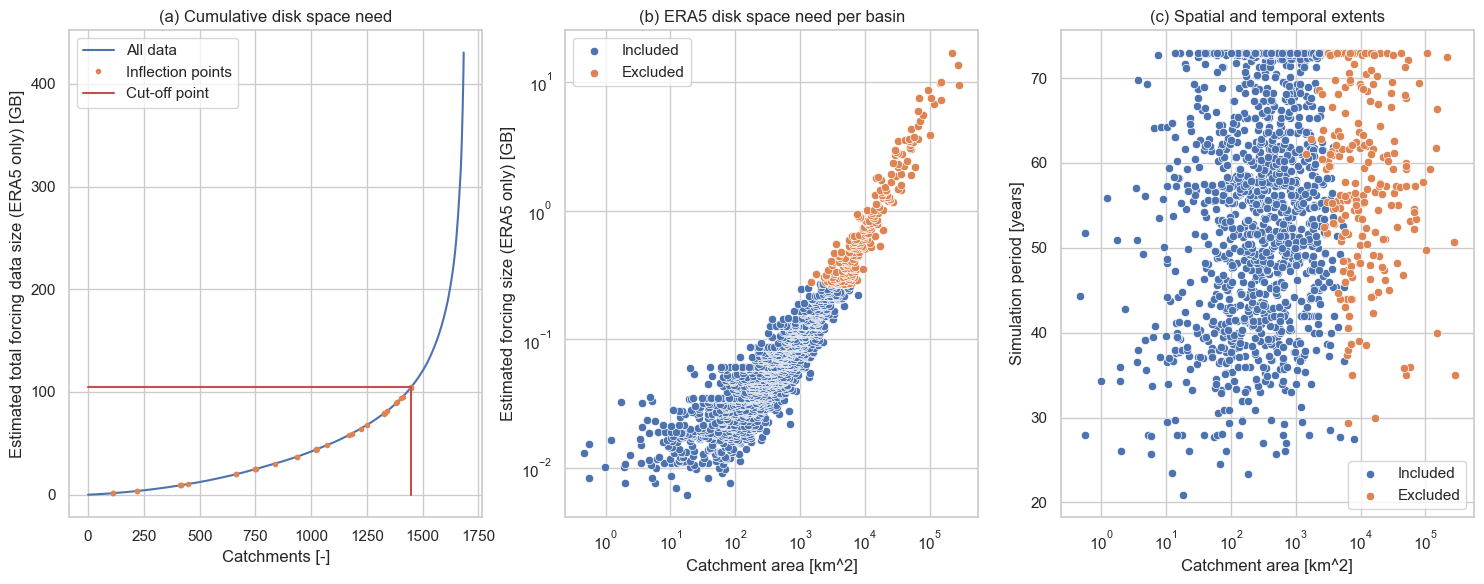

In [29]:
sns.set(style="whitegrid")

plt.figure(figsize=(15,6))

plt.subplot(131)
sns.lineplot(data=results['Estimated_total_data_size_gb'], label='All data')
plt.plot(inflection_points,linestyle='none',marker='.', label='Inflection points')
plt.plot([last_index,last_index],[0,last_data], 'r', label='Cut-off point')
plt.plot([0,last_index],[last_data,last_data], 'r')
plt.legend()
plt.xlabel('Catchments [-]')
plt.ylabel('Estimated total forcing data size (ERA5 only) [GB]')
plt.title('(a) Cumulative disk space need')

plt.subplot(132)
sns.scatterplot(data=results_included, x='Area_km2',y='Estimated_era5_data_size_gb', label='Included')
sns.scatterplot(data=results_excluded, x='Area_km2',y='Estimated_era5_data_size_gb', label='Excluded')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Catchment area [km^2]')
plt.ylabel('Estimated forcing size (ERA5 only) [GB]')
plt.title('(b) ERA5 disk space need per basin')

plt.subplot(133)
sns.scatterplot(data=results_included, x='Area_km2',y='Simulation_period_years', label='Included')
sns.scatterplot(data=results_excluded, x='Area_km2',y='Simulation_period_years', label='Excluded')
plt.xscale('log')
plt.legend()
plt.xlabel('Catchment area [km^2]')
plt.ylabel('Simulation period [years]')
plt.title('(c) Spatial and temporal extents')

plt.tight_layout()
plt.savefig(fig_folder/'camels_spat_estimated_era5_data_size.png', bbox_inches='tight', dpi=300)